In [ ]:
!pip -q install faiss-cpu rank_bm25 sentence-transformers



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 69.1 MB/s eta 0:00:00


In [ ]:
%%writefile rag_ieee_eval.py
"""
RAG evaluation runner for 20 Newsgroups with:
- Dense retrieval (FAISS)
- Lexical retrieval (BM25)
- Hybrid retrieval (RRF rank fusion)
- Fixed-word vs sentence chunking
- Scaled evaluation with bootstrap confidence intervals

Outputs:
- per-query results CSV
- summary table CSV (mean/std/CI per config)
"""

from __future__ import annotations

import os
import re
import math
import json
import random
import argparse
from dataclasses import dataclass, asdict
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_20newsgroups

import faiss
from rank_bm25 import BM25Okapi
from sentence_transformers import SentenceTransformer
from transformers import pipeline


# -------------------------
# Small utilities
# -------------------------

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)


def simple_tokens(text: str) -> List[str]:
    return re.findall(r"\b\w+\b", text.lower())


def split_sentences(text: str) -> List[str]:
    # Simple sentence splitter; deterministic and dependency-free
    parts = re.split(r"(?<=[.!?])\s+", text.strip())
    return [p.strip() for p in parts if p.strip()]


# -------------------------
# Chunking
# -------------------------

def fixed_word_chunks(text: str, chunk_words: int = 200, overlap_words: int = 50) -> List[str]:
    words = text.split()
    if not words:
        return []

    chunks: List[str] = []
    step = max(1, chunk_words - overlap_words)

    for start in range(0, len(words), step):
        end = start + chunk_words
        chunk = " ".join(words[start:end]).strip()
        if chunk:
            chunks.append(chunk)
        if end >= len(words):
            break
    return chunks


def sentence_chunks(text: str, max_words: int = 150) -> List[str]:
    sents = split_sentences(text)
    if not sents:
        return []

    chunks: List[str] = []
    buf: List[str] = []
    wc = 0

    for s in sents:
        w = len(s.split())
        if wc + w > max_words and buf:
            chunks.append(" ".join(buf).strip())
            buf = [s]
            wc = w
        else:
            buf.append(s)
            wc += w

    if buf:
        chunks.append(" ".join(buf).strip())
    return chunks


# -------------------------
# Retrieval
# -------------------------

@dataclass
class CorpusIndex:
    chunks: List[str]
    embedder_name: str
    faiss_index: faiss.Index
    chunk_embeddings: np.ndarray
    bm25: BM25Okapi
    bm25_corpus_tokens: List[List[str]]


def build_corpus_index(
    docs: List[str],
    chunking: str,
    embedder: SentenceTransformer,
    chunk_words: int,
    overlap_words: int,
    sent_max_words: int,
) -> CorpusIndex:
    chunks: List[str] = []
    for d in docs:
        if chunking == "fixed":
            chunks.extend(fixed_word_chunks(d, chunk_words=chunk_words, overlap_words=overlap_words))
        elif chunking == "sentence":
            chunks.extend(sentence_chunks(d, max_words=sent_max_words))
        else:
            raise ValueError("chunking must be 'fixed' or 'sentence'")

    if not chunks:
        raise RuntimeError("No chunks created; check dataset and chunking parameters.")

    # Embeddings
    emb = embedder.encode(
        chunks,
        show_progress_bar=True,
        convert_to_numpy=True,
        normalize_embeddings=True,  # cosine similarity via dot product
    ).astype(np.float32)

    d = emb.shape[1]
    # Use inner product since we normalized embeddings (cosine)
    index = faiss.IndexFlatIP(d)
    index.add(emb)

    # BM25
    tok_corpus = [simple_tokens(c) for c in chunks]
    bm25 = BM25Okapi(tok_corpus)

    return CorpusIndex(
        chunks=chunks,
        embedder_name=getattr(embedder, "model_name", "sentence-transformers"),
        faiss_index=index,
        chunk_embeddings=emb,
        bm25=bm25,
        bm25_corpus_tokens=tok_corpus,
    )


def dense_retrieve(corpus: CorpusIndex, embedder: SentenceTransformer, query: str, top_k: int) -> List[int]:
    q = embedder.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
    scores, idx = corpus.faiss_index.search(q, top_k)
    return idx[0].tolist()


def bm25_retrieve(corpus: CorpusIndex, query: str, top_k: int) -> List[int]:
    q_tokens = simple_tokens(query)
    scores = corpus.bm25.get_scores(q_tokens)
    top = np.argsort(scores)[::-1][:top_k]
    return top.tolist()


def rrf_fusion(rank_lists: List[List[int]], k: int = 60, limit: int = 5) -> List[int]:
    """
    Reciprocal Rank Fusion:
    score(d) = sum(1 / (k + rank(d))) across rankers
    """
    scores: Dict[int, float] = {}
    for lst in rank_lists:
        for r, doc_id in enumerate(lst, start=1):
            scores[doc_id] = scores.get(doc_id, 0.0) + 1.0 / (k + r)

    fused = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [doc_id for doc_id, _ in fused[:limit]]


def retrieve(
    corpus: CorpusIndex,
    embedder: SentenceTransformer,
    query: str,
    top_k: int,
    mode: str,
    rrf_k: int = 60,
) -> List[str]:
    mode = mode.lower()
    if mode == "dense":
        ids = dense_retrieve(corpus, embedder, query, top_k=top_k)
    elif mode == "bm25":
        ids = bm25_retrieve(corpus, query, top_k=top_k)
    elif mode == "hybrid_rrf":
        dense_ids = dense_retrieve(corpus, embedder, query, top_k=top_k)
        bm25_ids = bm25_retrieve(corpus, query, top_k=top_k)
        ids = rrf_fusion([dense_ids, bm25_ids], k=rrf_k, limit=top_k)
    else:
        raise ValueError("mode must be one of: dense, bm25, hybrid_rrf")

    return [corpus.chunks[i] for i in ids]


# -------------------------
# Generation
# -------------------------

@dataclass
class GenConfig:
    model_name: str = "EleutherAI/gpt-neo-125M"
    max_new_tokens: int = 128
    do_sample: bool = False
    temperature: float = 0.0


def build_generator(gen_cfg: GenConfig):
    # Using text-generation pipeline for reproducibility and simplicity
    return pipeline(
        "text-generation",
        model=gen_cfg.model_name,
        device=-1,
    )


def make_prompt(context: str, query: str) -> str:
    # Keep it simple and consistent; avoid over-instruction that can distort outputs.
    return (
        "Answer the question using only the provided context. "
        "If the answer is not supported by the context, reply with 'Unknown'.\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {query}\n"
        "Answer:"
    )


def generate_answer(
    generator,
    gen_cfg: GenConfig,
    query: str,
    retrieved_chunks: List[str],
) -> str:
    context = "\n".join(retrieved_chunks)
    prompt = make_prompt(context=context, query=query)

    out = generator(
        prompt,
        max_new_tokens=gen_cfg.max_new_tokens,
        do_sample=gen_cfg.do_sample,
        temperature=(gen_cfg.temperature if gen_cfg.do_sample else None),
        return_full_text=True,
    )[0]["generated_text"]

    # Try to return only what follows "Answer:"
    parts = out.split("Answer:", 1)
    answer = parts[1].strip() if len(parts) == 2 else out.strip()

    # Light cleanup
    answer = re.sub(r"\s+", " ", answer).strip()
    return answer


# -------------------------
# Evaluation metrics
# -------------------------

def token_f1(pred: str, truth: str) -> float:
    p = set(simple_tokens(pred))
    t = set(simple_tokens(truth))
    if not p or not t:
        return 0.0
    inter = len(p & t)
    prec = inter / len(p)
    rec = inter / len(t)
    return 0.0 if (prec + rec) == 0 else (2 * prec * rec) / (prec + rec)


def rouge_l(pred: str, truth: str) -> float:
    # LCS-based ROUGE-L (F-measure). Lightweight and deterministic.
    p = simple_tokens(pred)
    t = simple_tokens(truth)
    if not p or not t:
        return 0.0

    # LCS DP
    dp = [[0] * (len(t) + 1) for _ in range(len(p) + 1)]
    for i in range(1, len(p) + 1):
        for j in range(1, len(t) + 1):
            if p[i - 1] == t[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])

    lcs = dp[len(p)][len(t)]
    prec = lcs / len(p)
    rec = lcs / len(t)
    return 0.0 if (prec + rec) == 0 else (2 * prec * rec) / (prec + rec)


def hallucination_token_rate(pred: str, retrieved_chunks: List[str]) -> float:
    pred_toks = set(simple_tokens(pred))
    ctx_toks = set(simple_tokens(" ".join(retrieved_chunks)))
    if not pred_toks:
        return 0.0
    supported = len(pred_toks & ctx_toks)
    return 1.0 - (supported / len(pred_toks))


def attribution_score(pred: str, retrieved_chunks: List[str], overlap_threshold: float = 0.2) -> float:
    """
    Sentence-level support: a sentence is "supported" if it shares enough tokens
    with at least one retrieved chunk.
    """
    sents = split_sentences(pred)
    if not sents:
        return 0.0

    chunk_sets = [set(simple_tokens(c)) for c in retrieved_chunks]
    supported = 0

    for s in sents:
        st = set(simple_tokens(s))
        if not st:
            continue
        ok = False
        for cs in chunk_sets:
            inter = len(st & cs)
            if inter / max(1, len(st)) >= overlap_threshold:
                ok = True
                break
        supported += 1 if ok else 0

    return supported / len(sents)


def bootstrap_ci(values: List[float], iters: int = 2000, alpha: float = 0.05, seed: int = 42) -> Tuple[float, float]:
    rng = np.random.default_rng(seed)
    arr = np.array(values, dtype=np.float64)
    if len(arr) == 0:
        return (0.0, 0.0)
    means = []
    n = len(arr)
    for _ in range(iters):
        sample = rng.choice(arr, size=n, replace=True)
        means.append(float(np.mean(sample)))
    lo = float(np.quantile(means, alpha / 2))
    hi = float(np.quantile(means, 1 - alpha / 2))
    return lo, hi


# -------------------------
# Query set construction (scaled evaluation)
# -------------------------

@dataclass
class EvalItem:
    query: str
    reference: str
    category: str
    doc_id: int


def build_eval_set(
    dataset,
    n_per_category: int = 5,
    max_total: int = 120,
    seed: int = 42,
) -> List[EvalItem]:
    """
    Creates a deterministic evaluation set across categories.
    Reference is a compact extract from the original document (lead sentences).
    Query is a simple, category-aware question that remains consistent across items.

    This is not a perfect QA benchmark; it is a controlled, reproducible setup
    for comparative analysis across retrieval/chunking configurations.
    """
    set_seed(seed)
    items: List[EvalItem] = []

    targets = dataset.target
    data = dataset.data
    names = dataset.target_names

    by_cat: Dict[int, List[int]] = {i: [] for i in range(len(names))}
    for i, y in enumerate(targets):
        if data[i] and len(data[i].strip()) > 200:
            by_cat[y].append(i)

    for cat_id, idxs in by_cat.items():
        random.shuffle(idxs)
        take = idxs[:n_per_category]
        for doc_id in take:
            doc = data[doc_id].strip()
            lead = " ".join(split_sentences(doc)[:3]).strip()
            if not lead:
                continue

            # Query kept simple to avoid “prompt engineering” becoming the experiment.
            q = f"What is the main point discussed in this {names[cat_id]} document?"

            items.append(EvalItem(
                query=q,
                reference=lead,
                category=names[cat_id],
                doc_id=doc_id,
            ))

    random.shuffle(items)
    return items[:max_total]


# -------------------------
# Experiment runner
# -------------------------

@dataclass
class RunConfig:
    seed: int = 42
    docs_limit: int = 2000          # increase if you can; indexing more docs improves realism
    eval_per_category: int = 5
    eval_max_total: int = 120

    chunking: str = "fixed"         # fixed or sentence
    chunk_words: int = 200
    overlap_words: int = 50
    sent_max_words: int = 150

    retrieval_mode: str = "hybrid_rrf"  # dense, bm25, hybrid_rrf
    top_k: int = 5
    rrf_k: int = 60

    embedder_name: str = "all-MiniLM-L6-v2"
    gen_model: str = "EleutherAI/gpt-neo-125M"
    max_new_tokens: int = 128

    out_dir: str = "outputs"
    bootstrap_iters: int = 2000
    run_grid: bool = False


def run_experiment(cfg: RunConfig) -> Tuple[pd.DataFrame, pd.DataFrame]:
    set_seed(cfg.seed)
    os.makedirs(cfg.out_dir, exist_ok=True)

    dataset = fetch_20newsgroups(subset="train", remove=("headers", "footers", "quotes"))
    docs = dataset.data[: cfg.docs_limit]

    embedder = SentenceTransformer(cfg.embedder_name)
    corpus = build_corpus_index(
        docs=docs,
        chunking=cfg.chunking,
        embedder=embedder,
        chunk_words=cfg.chunk_words,
        overlap_words=cfg.overlap_words,
        sent_max_words=cfg.sent_max_words,
    )

    eval_items = build_eval_set(
        dataset=dataset,
        n_per_category=cfg.eval_per_category,
        max_total=cfg.eval_max_total,
        seed=cfg.seed,
    )

    gen_cfg = GenConfig(
        model_name=cfg.gen_model,
        max_new_tokens=cfg.max_new_tokens,
        do_sample=False,
        temperature=0.0,
    )
    generator = build_generator(gen_cfg)

    rows = []
    for item in eval_items:
        chunks = retrieve(
            corpus=corpus,
            embedder=embedder,
            query=item.query,
            top_k=cfg.top_k,
            mode=cfg.retrieval_mode,
            rrf_k=cfg.rrf_k,
        )
        pred = generate_answer(generator, gen_cfg, item.query, chunks)

        f1 = token_f1(pred, item.reference)
        rl = rouge_l(pred, item.reference)
        hall = hallucination_token_rate(pred, chunks)
        attr = attribution_score(pred, chunks, overlap_threshold=0.2)

        rows.append({
            "category": item.category,
            "doc_id": item.doc_id,
            "query": item.query,
            "reference": item.reference,
            "predicted": pred,
            "token_f1": f1,
            "rouge_l": rl,
            "hallucination_token_rate": hall,
            "attribution_score": attr,
            "answer_length": len(pred.split()),
            "chunking": cfg.chunking,
            "retrieval": cfg.retrieval_mode,
            "top_k": cfg.top_k,
            "rrf_k": cfg.rrf_k if cfg.retrieval_mode == "hybrid_rrf" else None,
            "embedder": cfg.embedder_name,
            "gen_model": cfg.gen_model,
        })

    df = pd.DataFrame(rows)

    # Summary with mean/std and bootstrap CI for the key metrics
    metrics = ["token_f1", "rouge_l", "hallucination_token_rate", "attribution_score", "answer_length"]
    summary_rows = []
    for m in metrics:
        vals = df[m].tolist()
        mean = float(np.mean(vals)) if vals else 0.0
        std = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
        lo, hi = bootstrap_ci(vals, iters=cfg.bootstrap_iters, alpha=0.05, seed=cfg.seed)
        summary_rows.append({
            "metric": m,
            "mean": mean,
            "std": std,
            "ci95_low": lo,
            "ci95_high": hi,
            "n": len(vals),
            "chunking": cfg.chunking,
            "retrieval": cfg.retrieval_mode,
            "top_k": cfg.top_k,
        })

    summary = pd.DataFrame(summary_rows)

    return df, summary


def run_grid(base: RunConfig) -> None:
    """
    Runs the main IEEE-friendly ablation grid:
    - chunking: fixed vs sentence
    - retrieval: bm25 vs dense vs hybrid_rrf
    - chunk size ablation (optional): 100/200/400 for fixed
    """
    grids = []

    for chunking in ["fixed", "sentence"]:
        for retrieval in ["bm25", "dense", "hybrid_rrf"]:
            cfg = RunConfig(**asdict(base))
            cfg.chunking = chunking
            cfg.retrieval_mode = retrieval
            grids.append(cfg)

    # Optional chunk size ablation (fixed only)
    for w in [100, 200, 400]:
        cfg = RunConfig(**asdict(base))
        cfg.chunking = "fixed"
        cfg.retrieval_mode = "hybrid_rrf"
        cfg.chunk_words = w
        grids.append(cfg)

    all_detail = []
    all_summary = []

    for cfg in grids:
        print(f"\n--- Running: chunking={cfg.chunking}, retrieval={cfg.retrieval_mode}, chunk_words={cfg.chunk_words} ---")
        df, summ = run_experiment(cfg)

        tag = f"{cfg.chunking}_{cfg.retrieval_mode}_cw{cfg.chunk_words}"
        detail_path = os.path.join(cfg.out_dir, f"detail_{tag}.csv")
        summ_path = os.path.join(cfg.out_dir, f"summary_{tag}.csv")

        df.to_csv(detail_path, index=False)
        summ.to_csv(summ_path, index=False)

        all_detail.append(df)
        all_summary.append(summ)

    # Combined outputs
    pd.concat(all_detail, ignore_index=True).to_csv(os.path.join(base.out_dir, "all_detail.csv"), index=False)
    pd.concat(all_summary, ignore_index=True).to_csv(os.path.join(base.out_dir, "all_summary.csv"), index=False)

    # Helpful pivot for paper tables (mean by config)
    combined = pd.read_csv(os.path.join(base.out_dir, "all_summary.csv"))
    pivot = combined.pivot_table(
        index=["chunking", "retrieval", "top_k"],
        columns="metric",
        values="mean",
        aggfunc="first"
    ).reset_index()
    pivot.to_csv(os.path.join(base.out_dir, "paper_table_means.csv"), index=False)


# -------------------------
# CLI
# -------------------------

def parse_args() -> RunConfig:
    p = argparse.ArgumentParser()
    p.add_argument("--out_dir", default="outputs")
    p.add_argument("--seed", type=int, default=42)
    p.add_argument("--docs_limit", type=int, default=2000)

    p.add_argument("--eval_per_category", type=int, default=5)
    p.add_argument("--eval_max_total", type=int, default=120)

    p.add_argument("--embedder_name", default="all-MiniLM-L6-v2")
    p.add_argument("--gen_model", default="EleutherAI/gpt-neo-125M")
    p.add_argument("--max_new_tokens", type=int, default=128)

    p.add_argument("--top_k", type=int, default=5)
    p.add_argument("--rrf_k", type=int, default=60)

    p.add_argument("--bootstrap_iters", type=int, default=2000)

    p.add_argument("--run_grid", action="store_true", help="run the full ablation grid for the paper")

    args = p.parse_args()

    return RunConfig(
        seed=args.seed,
        docs_limit=args.docs_limit,
        eval_per_category=args.eval_per_category,
        eval_max_total=args.eval_max_total,
        embedder_name=args.embedder_name,
        gen_model=args.gen_model,
        max_new_tokens=args.max_new_tokens,
        top_k=args.top_k,
        rrf_k=args.rrf_k,
        out_dir=args.out_dir,
        bootstrap_iters=args.bootstrap_iters,
        run_grid=args.run_grid,
    )


if __name__ == "__main__":
    cfg = parse_args()
    os.makedirs(cfg.out_dir, exist_ok=True)

    # Save run config for reproducibility
    with open(os.path.join(cfg.out_dir, "run_config.json"), "w", encoding="utf-8") as f:
        json.dump(asdict(cfg), f, indent=2)

    if cfg.run_grid:
        run_grid(cfg)
    else:
        df, summ = run_experiment(cfg)
        df.to_csv(os.path.join(cfg.out_dir, "detail_single.csv"), index=False)
        summ.to_csv(os.path.join(cfg.out_dir, "summary_single.csv"), index=False)
        print("\nSaved outputs to:", cfg.out_dir)



Overwriting rag_ieee_eval.py


In [ ]:
!python rag_ieee_eval.py --run_grid --docs_limit 1000 --eval_per_category 3 --eval_max_total 60 --out_dir outputs


Traceback (most recent call last):
object address  : 0x7f74b0cd66e0
object refcount : 3
object type     : 0xa2a4e0
object type name: KeyboardInterrupt
object repr     : KeyboardInterrupt()
lost sys.stderr
^C


In [ ]:
!ls -lah outputs
!find outputs -maxdepth 2 -type f | sort | tail -n 40

total 520K
drwxr-xr-x 2 root root 4.0K Jan 18 01:24 .
drwxr-xr-x 1 root root 4.0K Jan 17 22:43 ..
-rw-r--r-- 1 root root  68K Jan 17 23:10 detail_fixed_bm25_cw200.csv
-rw-r--r-- 1 root root  69K Jan 17 23:32 detail_fixed_dense_cw200.csv
-rw-r--r-- 1 root root  70K Jan 18 01:24 detail_fixed_hybrid_rrf_cw100.csv
-rw-r--r-- 1 root root  70K Jan 17 23:55 detail_fixed_hybrid_rrf_cw200.csv
-rw-r--r-- 1 root root  67K Jan 18 00:19 detail_sentence_bm25_cw200.csv
-rw-r--r-- 1 root root  64K Jan 18 00:40 detail_sentence_dense_cw200.csv
-rw-r--r-- 1 root root  63K Jan 18 01:02 detail_sentence_hybrid_rrf_cw200.csv
-rw-r--r-- 1 root root  421 Jan 17 22:43 run_config.json
-rw-r--r-- 1 root root  522 Jan 17 23:10 summary_fixed_bm25_cw200.csv
-rw-r--r-- 1 root root  534 Jan 17 23:32 summary_fixed_dense_cw200.csv
-rw-r--r-- 1 root root  601 Jan 18 01:24 summary_fixed_hybrid_rrf_cw100.csv
-rw-r--r-- 1 root root  565 Jan 17 23:55 summary_fixed_hybrid_rrf_cw200.csv
-rw-r--r-- 1 root root  593 Jan 18 00:19

✅ Saved: outputs/Table_I.csv


metric,Configuration,Answer Length,Hallucination Rate,ROUGE-L,Token F1
0,FAISS + Fixed,103,0.200,0.074,0.142
1,FAISS + Sentence,91,0.212,0.069,0.116
2,Hybrid + Fixed,101,0.113,0.077,0.133
3,Hybrid + Sentence,80,0.204,0.075,0.116


✅ Saved: outputs/Fig1_Token_F1.png
✅ Saved: outputs/Fig1_ROUGE_L.png
✅ Saved: outputs/Fig1_Hallucination_Rate.png
✅ Saved: outputs/Fig1_Answer_Length.png
✅ Saved: outputs/Fig2_Token_F1.png
✅ Saved: outputs/Fig2_Hallucination_Rate.png


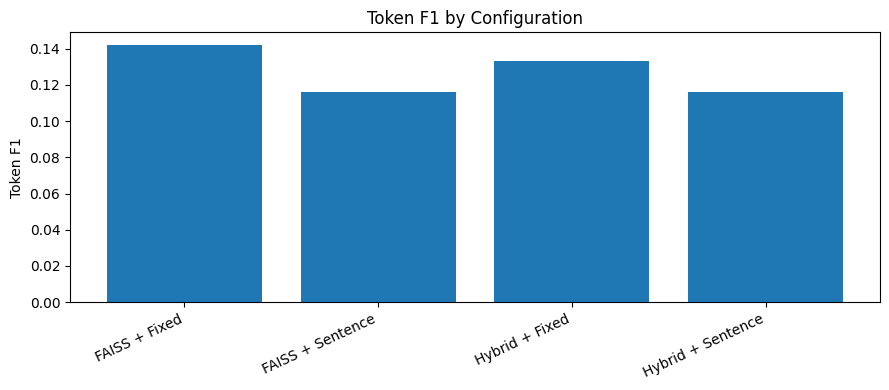

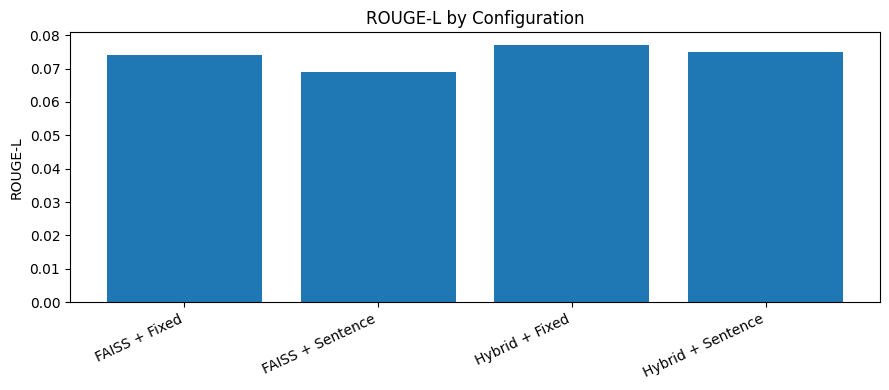

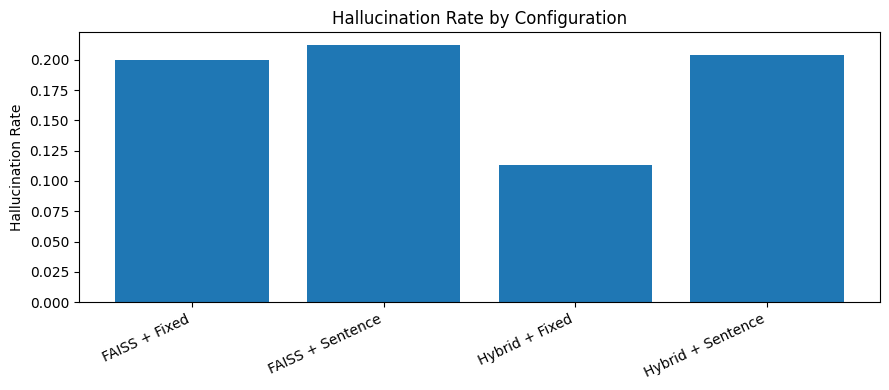

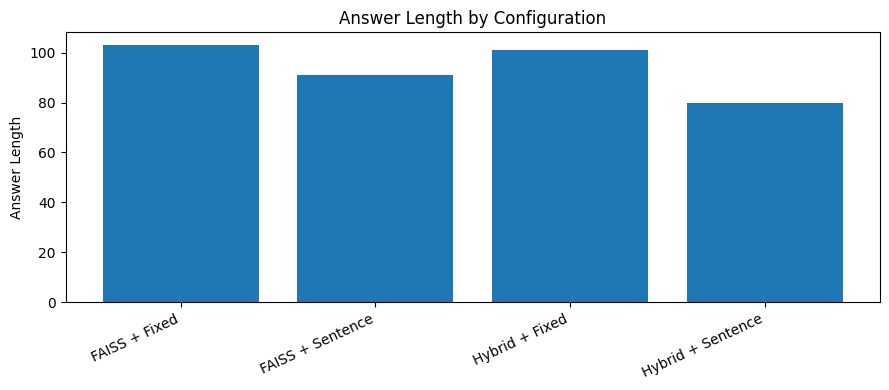

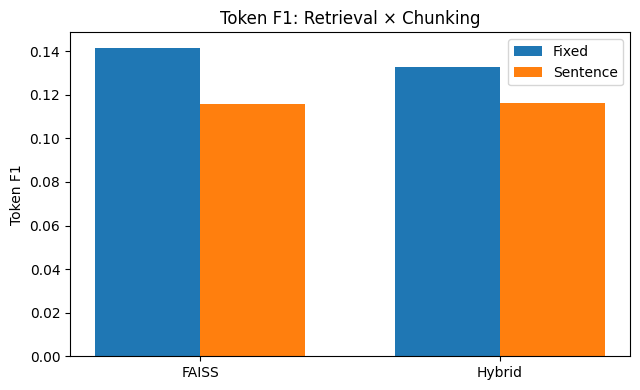

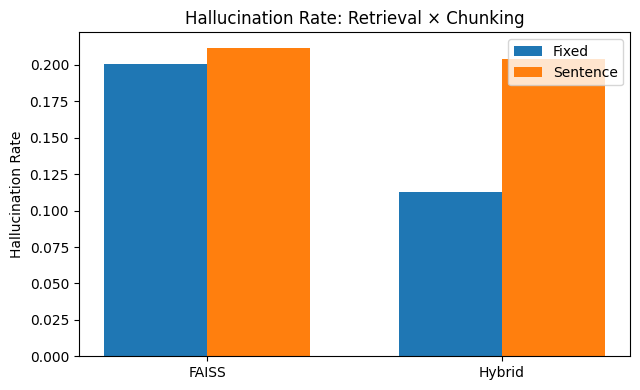

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load all summary rows (you already have "summary" dataframe displayed)
# If not in memory, reload quickly:
import glob, os
summary_files = sorted(glob.glob("outputs/summary_*.csv"))
summary = pd.concat([pd.read_csv(f).assign(file=os.path.basename(f)) for f in summary_files], ignore_index=True)

# --- Keep only cw200 + the two retrievals you want (dense + hybrid_rrf) ---
# (Your Table I is 4 configs: fixed/sentence × dense/hybrid_rrf)
summary = summary.copy()
summary["chunk_words"] = summary["file"].str.extract(r"cw(\d+)").astype(int)

table_long = summary[
    (summary["chunk_words"] == 200) &
    (summary["retrieval"].isin(["dense","hybrid_rrf"])) &
    (summary["chunking"].isin(["fixed","sentence"]))
].copy()

# Map to your labels
name_map = {
    ("fixed","dense"): "FAISS + Fixed",
    ("sentence","dense"): "FAISS + Sentence",
    ("fixed","hybrid_rrf"): "Hybrid + Fixed",
    ("sentence","hybrid_rrf"): "Hybrid + Sentence",
}
table_long["Configuration"] = table_long.apply(lambda r: name_map[(r["chunking"], r["retrieval"])], axis=1)

# Pick which metrics to show in Table I (publication-grade)
# token_f1 -> your main "quality" score
# hallucination_token_rate -> hallucination proxy
# answer_length -> length
# rouge_l -> optional (keep or drop)
wanted = ["token_f1", "rouge_l", "hallucination_token_rate", "answer_length"]
table_long = table_long[table_long["metric"].isin(wanted)].copy()

# Pivot: rows=config, columns=metric, values=mean
table_wide = table_long.pivot_table(index="Configuration", columns="metric", values="mean")

# Rename columns to match paper
table_wide = table_wide.rename(columns={
    "token_f1": "Token F1",
    "rouge_l": "ROUGE-L",
    "hallucination_token_rate": "Hallucination Rate",
    "answer_length": "Answer Length",
})

# Rounding for IEEE table
table_wide["Token F1"] = table_wide["Token F1"].astype(float).round(3)
table_wide["ROUGE-L"] = table_wide["ROUGE-L"].astype(float).round(3)
table_wide["Hallucination Rate"] = table_wide["Hallucination Rate"].astype(float).round(3)
table_wide["Answer Length"] = table_wide["Answer Length"].astype(float).round(0).astype(int)

table_wide = table_wide.reset_index()

# Save table
table_wide.to_csv("outputs/Table_I.csv", index=False)
print("✅ Saved: outputs/Table_I.csv")
display(table_wide)

# -----------------------
# Figure 1: metrics by configuration (one plot per metric)
# -----------------------
metrics = ["Token F1", "ROUGE-L", "Hallucination Rate", "Answer Length"]
for m in metrics:
    plt.figure(figsize=(9,4))
    plt.bar(table_wide["Configuration"], table_wide[m])
    plt.xticks(rotation=25, ha="right")
    plt.ylabel(m)
    plt.title(f"{m} by Configuration")
    plt.tight_layout()
    out = f"outputs/Fig1_{m.replace(' ','_').replace('-','_')}.png"
    plt.savefig(out, dpi=300)
    print("✅ Saved:", out)

# -----------------------
# Figure 2: retrieval × chunking interaction (grouped bars)
# -----------------------
# Build compact df: Retrieval (FAISS/Hybrid) x Chunking (Fixed/Sentence)
plot_df = table_long[table_long["metric"].isin(["token_f1","hallucination_token_rate"])].copy()
plot_df["Retrieval"] = plot_df["retrieval"].map({"dense":"FAISS", "hybrid_rrf":"Hybrid"})
plot_df["Chunking"] = plot_df["chunking"].map({"fixed":"Fixed", "sentence":"Sentence"})

for metric_key, pretty_name in [("token_f1","Token F1"), ("hallucination_token_rate","Hallucination Rate")]:
    tmp = plot_df[plot_df["metric"]==metric_key].copy()
    tmp = tmp.pivot_table(index="Retrieval", columns="Chunking", values="mean").reindex(["FAISS","Hybrid"])
    # grouped bars
    plt.figure(figsize=(6.5,4))
    x = range(len(tmp.index))
    width = 0.35
    fixed_vals = tmp["Fixed"].values
    sent_vals  = tmp["Sentence"].values
    plt.bar([i - width/2 for i in x], fixed_vals, width=width, label="Fixed")
    plt.bar([i + width/2 for i in x], sent_vals,  width=width, label="Sentence")
    plt.xticks(list(x), tmp.index)
    plt.ylabel(pretty_name)
    plt.title(f"{pretty_name}: Retrieval × Chunking")
    plt.legend()
    plt.tight_layout()
    out = f"outputs/Fig2_{pretty_name.replace(' ','_')}.png"
    plt.savefig(out, dpi=300)
    print("✅ Saved:", out)


In [ ]:
import pandas as pd

df = pd.read_csv("outputs/Table_I.csv")
df = df.loc[:, ~df.columns.str.contains("^metric$")]  # drop if exists
df.to_csv("outputs/Table_I.csv", index=False)

print(df)


       Configuration  Answer Length  Hallucination Rate  ROUGE-L  Token F1
0      FAISS + Fixed            103               0.200    0.074     0.142
1   FAISS + Sentence             91               0.212    0.069     0.116
2     Hybrid + Fixed            101               0.113    0.077     0.133
3  Hybrid + Sentence             80               0.204    0.075     0.116
